In [27]:
import ast
import torch
import numpy as np
import pandas as pd
from itertools import product
from collections import defaultdict
import matplotlib.patches as mpatches
from torch_geometric.data import HeteroData
from sklearn.metrics.pairwise import cosine_similarity



In [28]:

# Load your CSV
df = pd.read_csv("../comments_w_embeddings/comments_df_with_embeddings2.csv")

# Parse datetime and embeddings
df["created"] = pd.to_datetime(df["created"])
df["embeddings"] = df["embeddings"].apply(ast.literal_eval)
df["emotion_probs"] = df["emotion_probs"].apply(ast.literal_eval)

# Add parent_comment_id
df["parent_comment_id"] = df["parent_id"].apply(lambda pid: pid[3:] if isinstance(pid, str) and pid.startswith("t1_") else None)

# Node Tables
# Unique user nodes
user_nodes = df["author"].dropna().unique()
user_nodes_df = pd.DataFrame(user_nodes, columns=["user_id"])

# Unique comment nodes
comment_nodes_df = df[["id", "created", "author", "embeddings", "emotion_probs"]].copy()
comment_nodes_df.rename(columns={"id": "comment_id"}, inplace=True)

# Edge Tables


# a) User → Comment (authorship)
user_comment_edges = df[["author", "id"]].rename(columns={"author": "user_id", "id": "comment_id"})

# b) Comment → Comment (reply)
comment_reply_edges = df.dropna(subset=["parent_comment_id"])[["parent_comment_id", "id"]].rename(
    columns={"parent_comment_id": "source_comment", "id": "target_comment"}
)

# User → User (Influence with comment-level info and emotion shift)

comment_data = {
    row["id"]: {
        "embedding": np.array(row["embeddings"]),
        "emotion": row["emotion_probs"],
        "timestamp": row["created"],
        "author": row["author"]
    }
    for _, row in df.iterrows()
}

influence_edges = []

emotion_keys = list(df["emotion_probs"].iloc[0].keys())

for id_a, id_b in product(df["id"], repeat=2):
    if id_a == id_b:
        continue

    ca, cb = comment_data[id_a], comment_data[id_b]

    # Skip same author or backward-in-time influence
    if ca["author"] == cb["author"]:
        continue
    delta_t = (cb["timestamp"] - ca["timestamp"]).total_seconds()
    if delta_t <= 0 or delta_t > 86400:
        continue

    # Semantic similarity between embeddings
    sem_sim = cosine_similarity([ca["embedding"]], [cb["embedding"]])[0][0]
    if sem_sim < 0.75:
        continue

    # Emotion shift vector and total shift
    emo_transfer = {k: cb["emotion"][k] - ca["emotion"][k] for k in emotion_keys}
    total_emotion_shift = sum(abs(v) for v in emo_transfer.values())

    # Determine dominant emotion
    dominant_emotion = max(emo_transfer.items(), key=lambda x: abs(x[1]))[0]

    # Save edge with dominant emotion
    influence_edges.append({
        "source_user": ca["author"],
        "target_user": cb["author"],
        "source_comment": id_a,
        "target_comment": id_b,
        "time_delta_seconds": delta_t,
        "semantic_similarity": sem_sim,
        "emotion_transfer_vector": emo_transfer,
        "total_emotion_shift": total_emotion_shift,
        "dominant_emotion": dominant_emotion  
    })

influence_edges_df = pd.DataFrame(influence_edges)
# Update user_nodes_df
user_nodes_df['user_id'] = user_nodes_df['user_id'].replace('CheekSpreader91', 'CS91')

# Update user_comment_edges
user_comment_edges['user_id'] = user_comment_edges['user_id'].replace('CheekSpreader91', 'CS91')

# Update comment_reply_edges
# comment_reply_edges['source_user'] = comment_reply_edges['source_user'].replace('CheekSpreader91', 'CS91')
# comment_reply_edges['target_user'] = comment_reply_edges['target_user'].replace('CheekSpreader91', 'CS91')

# Update influence_edges_df
influence_edges_df['source_user'] = influence_edges_df['source_user'].replace('CheekSpreader91', 'CS91')
influence_edges_df['target_user'] = influence_edges_df['target_user'].replace('CheekSpreader91', 'CS91')


In [29]:
influence_edges_df

,source_user,target_user,source_comment,target_comment,time_delta_seconds,semantic_similarity,emotion_transfer_vector,total_emotion_shift,dominant_emotion
0,FragmentedCoast,CS91,lzvlxta,lzxenbx,20423.0,0.775331,"{'amusement': 0.004540473222732544, 'anger': -...",0.929746,caring
1,TACK_OVERFLOW,CS91,lzvn8kk,lzvu88t,2429.0,0.816397,"{'amusement': 0.12073323130607605, 'anger': 0....",0.801065,optimism
2,TACK_OVERFLOW,Coollogin,lzvn8kk,lzvvkl7,2890.0,0.813571,"{'amusement': 0.14441782236099243, 'anger': -0...",0.979335,optimism
3,TheTallestTim,CS91,lzx7att,lzxenbx,2256.0,0.846603,"{'amusement': 0.018258213996887207, 'anger': -...",1.234132,optimism
4,CS91,Coollogin,lzvu88t,lzvvkl7,461.0,0.904080,"{'amusement': 0.023684591054916382, 'anger': -...",0.709380,caring
5,CS91,Coollogin,lzvu88t,lzwk93j,8275.0,0.809916,"{'amusement': -0.1341397762298584, 'anger': 0....",1.248218,approval


In [30]:
user_nodes_df

,user_id
0,[deleted]
1,FragmentedCoast
2,TACK_OVERFLOW
3,Coollogin
4,TheTallestTim
5,CS91


In [31]:
comment_nodes_df

,comment_id,created,author,embeddings,emotion_probs
0,lzvl77e,2024-12-01 14:57:13,[deleted],"[1.1415131092071533, -0.5668041706085205, -0.3...","{'amusement': 0.543026328086853, 'anger': 0.23..."
1,lzvlxta,2024-12-01 15:01:48,FragmentedCoast,"[0.30898192524909973, -1.471962332725525, -0.4...","{'amusement': 0.18271403014659882, 'anger': 0...."
2,lzvn8kk,2024-12-01 15:09:46,TACK_OVERFLOW,"[0.4844473898410797, -0.8923026919364929, 0.04...","{'amusement': 0.30988749861717224, 'anger': 0...."
3,lzvroec,2024-12-01 15:35:45,Coollogin,"[0.7027660012245178, -1.4075536727905273, -0.5...","{'amusement': 0.3518975079059601, 'anger': 0.2..."
4,lzx7att,2024-12-01 20:04:35,TheTallestTim,"[-0.3662604093551636, -0.9887987971305847, -0....","{'amusement': 0.16899628937244415, 'anger': 0...."
5,lzvq2iz,2024-12-01 15:26:26,CheekSpreader91,"[0.16952763497829437, -0.45102065801620483, 0....","{'amusement': 0.156666561961174, 'anger': 0.12..."
6,lzvqmcw,2024-12-01 15:29:40,CheekSpreader91,"[-0.1517835259437561, -0.8439221382141113, 0.0...","{'amusement': 0.3937270939350128, 'anger': 0.1..."
7,lzvqv8z,2024-12-01 15:31:07,CheekSpreader91,"[-0.14351555705070496, -1.1086206436157227, 0....","{'amusement': 0.4407764971256256, 'anger': 0.1..."
8,lzvu88t,2024-12-01 15:50:15,CheekSpreader91,"[0.25016188621520996, -0.9155450463294983, -0....","{'amusement': 0.4306207299232483, 'anger': 0.1..."
9,lzxenbx,2024-12-01 20:42:11,CheekSpreader91,"[-0.16394589841365814, -0.6975420117378235, -0...","{'amusement': 0.18725450336933136, 'anger': 0...."


In [32]:
user_comment_edges

,user_id,comment_id
0,[deleted],lzvl77e
1,FragmentedCoast,lzvlxta
2,TACK_OVERFLOW,lzvn8kk
3,Coollogin,lzvroec
4,TheTallestTim,lzx7att
5,CS91,lzvq2iz
6,CS91,lzvqmcw
7,CS91,lzvqv8z
8,CS91,lzvu88t
9,CS91,lzxenbx


In [33]:
comment_reply_edges

,source_comment,target_comment
5,lzvl77e,lzvq2iz
6,lzvlxta,lzvqmcw
7,lzvn8kk,lzvqv8z
8,lzvroec,lzvu88t
9,lzx7att,lzxenbx
10,lzvqmcw,lzvyyec
11,lzvu88t,lzvvkl7
12,lzxenbx,m04ntyb
13,lzvyyec,lzw0mzl
14,lzvvkl7,lzvy18o


In [34]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add user nodes
for user in user_nodes_df["user_id"]:
    G.add_node(user, type="user")

# Add comment nodes
for _, row in comment_nodes_df.iterrows():
    G.add_node(row["comment_id"], type="comment")

# Add edges
# a) User → Comment (authorship)
for _, row in user_comment_edges.iterrows():
    G.add_edge(row["user_id"], row["comment_id"], type="authorship")

# b) Comment → Comment (reply)
for _, row in comment_reply_edges.iterrows():
    G.add_edge(row["source_comment"], row["target_comment"], type="reply")

# c) User → User (influence)
for _, row in influence_edges_df.iterrows():
    G.add_edge(
        row["source_user"], row["target_user"],
        type="influence",
        source_comment=row["source_comment"],
        target_comment=row["target_comment"],
        emotion_transfer=row["emotion_transfer_vector"],
        total_emotion_shift=row["total_emotion_shift"],
        dominant_emotion=row["dominant_emotion"]
    )


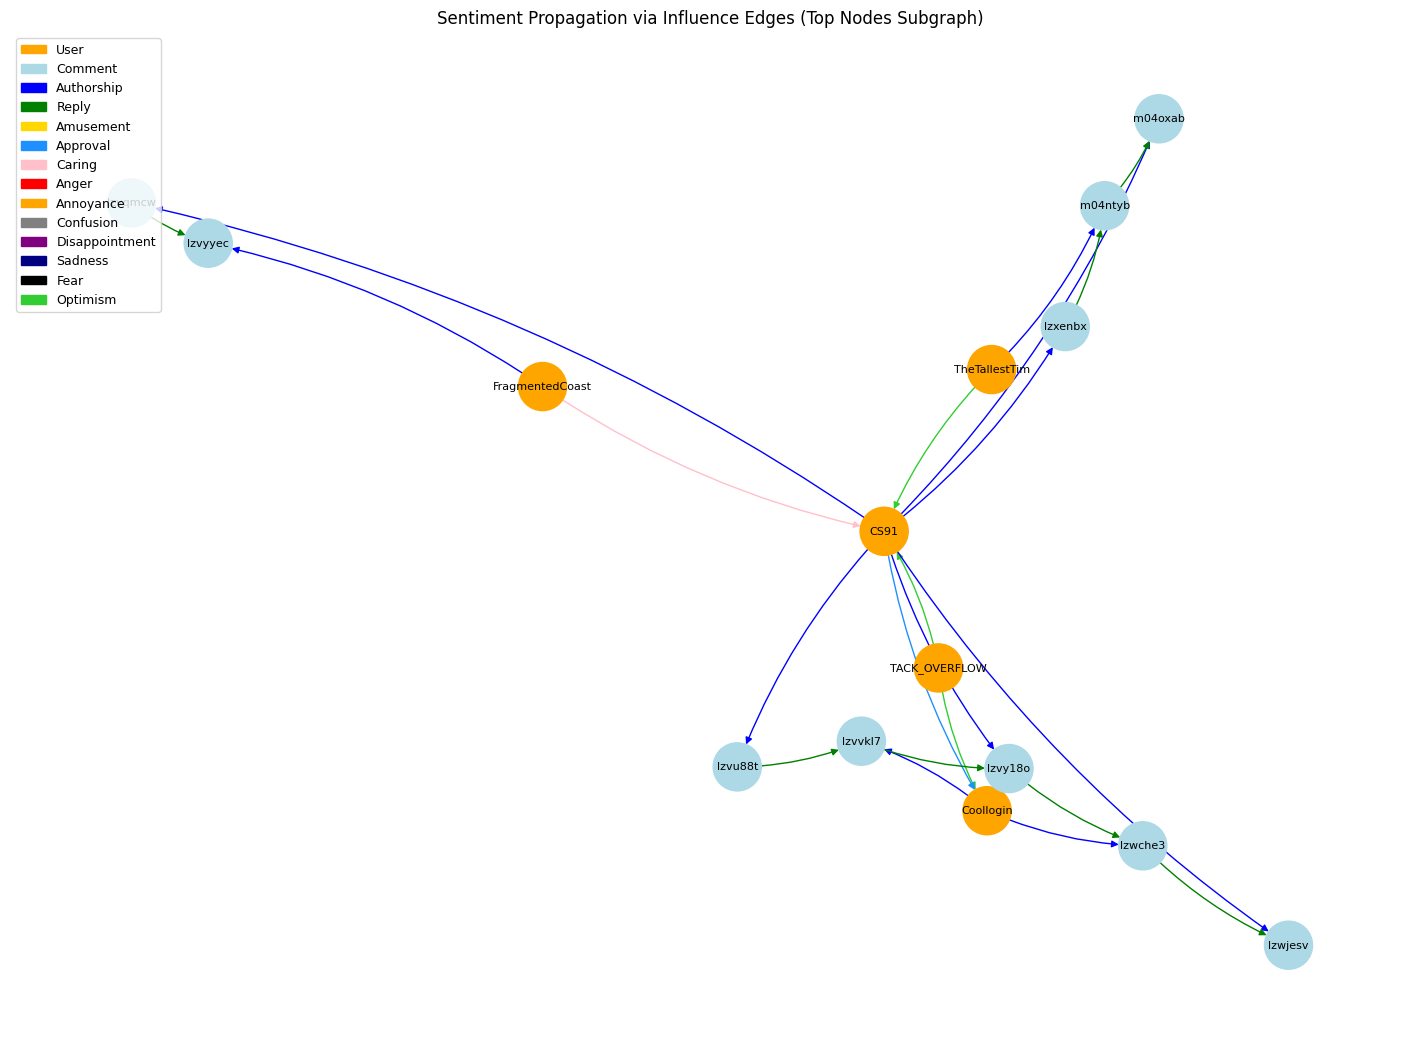

In [35]:



# Compute subgraph and layout
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:15]
subgraph_nodes = [node for node, _ in top_nodes]
SG = G.subgraph(subgraph_nodes)
pos = nx.spring_layout(SG, seed=42)

emotion_colors = {
    "amusement": "gold",
    "approval": "dodgerblue",
    "caring": "pink",
    "anger": "red",
    "annoyance": "orange",
    "confusion": "gray",
    "disappointment": "purple",
    "sadness": "navy",
    "fear": "black",
    "optimism": "limegreen",
    "gratitude": "lime",
    "pride": "teal",
    "remorse": "brown",
    "surprise": "magenta"
}


# Node colors
node_colors = ['orange' if SG.nodes[n].get('type') == 'user' else 'lightblue' for n in SG.nodes()]

# Edge colors based on type and dominant emotion for 'influence'
edge_colors = []
for u, v in SG.edges():
    edge_type = SG[u][v].get('type')
    if edge_type == 'influence':
        dom_emo = SG[u][v].get('dominant_emotion')
        edge_colors.append(emotion_colors.get(dom_emo, 'black'))
    elif edge_type == 'authorship':
        edge_colors.append('blue')
    elif edge_type == 'reply':
        edge_colors.append('green')
    else:
        edge_colors.append('black')

# Draw graph
plt.figure(figsize=(14, 10))
nx.draw(SG, pos,
        with_labels=True,
        node_color=node_colors,
        edge_color=edge_colors,
        node_size=1200,
        font_size=8,
        arrows=True,
        connectionstyle="arc3,rad=0.1")

# Legend patches
node_legend = [
    mpatches.Patch(color='orange', label='User'),
    mpatches.Patch(color='lightblue', label='Comment')
]

edge_legend = [
    mpatches.Patch(color='blue', label='Authorship'),
    mpatches.Patch(color='green', label='Reply')
]

emotion_legend = [mpatches.Patch(color=color, label=emotion.title()) 
                  for emotion, color in emotion_colors.items()]

plt.legend(handles=node_legend + edge_legend + emotion_legend[:10],  # Add more as needed
           loc='upper left', fontsize=9, frameon=True)

plt.title("Sentiment Propagation via Influence Edges (Top Nodes Subgraph)")
plt.show()


In [36]:
# config
emotion_list = [
    'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'disappointment', 'disapproval', 'disgust',
    'excitement', 'fear', 'gratitude', 'joy', 'love', 'optimism', 'pride',
    'remorse', 'sadness', 'surprise', 'neutral'
]

def dict_to_vec(emotion_dict, keys):
    return np.array([emotion_dict.get(k, 0.0) for k in keys])

def calculate_influence_score(parent_sent, child_sent, t1, t2, emb1, emb2):
    sentiment_sim = cosine_similarity([parent_sent], [child_sent])[0][0]
    content_sim = cosine_similarity([emb1], [emb2])[0][0]
    time_decay = np.exp(-(t2 - t1) / 3600)
    return sentiment_sim * content_sim * time_decay

def process_data(comment_csv_path):
    df = pd.read_csv(comment_csv_path)
    df["created"] = pd.to_datetime(df["created"])
    df["emotion_probs"] = df["emotion_probs"].apply(ast.literal_eval)
    df["embeddings"] = df["embeddings"].apply(ast.literal_eval)
    df["parent_comment_id"] = df["parent_id"].apply(lambda pid: pid[3:] if isinstance(pid, str) and pid.startswith("t1_") else None)

    conversation = {
        "users": defaultdict(lambda: {"comments": [], "sentiment_history": [], "influences": defaultdict(list), "influenced_by": defaultdict(list), "total_influence": 0}),
        "comments": {},
        "chains": defaultdict(list)
    }

    df = df.sort_values("created")
    for _, row in df.iterrows():
        comment_id = row["id"]
        author = row["author"]
        parent_id = row["parent_comment_id"]
        sentiment = dict_to_vec(row["emotion_probs"], emotion_list)
        timestamp = row["created"].timestamp()
        embedding = np.array(row["embeddings"])

        conversation["comments"][comment_id] = {
            "author": author,
            "sentiment": sentiment,
            "timestamp": timestamp,
            "embedding": embedding,
            "parent_id": parent_id
        }

        conversation["users"][author]["comments"].append(comment_id)
        conversation["users"][author]["sentiment_history"].append((sentiment, timestamp))

        if parent_id and parent_id in conversation["comments"]:
            parent = conversation["comments"][parent_id]
            parent_author = parent["author"]
            influence = calculate_influence_score(parent["sentiment"], sentiment, parent["timestamp"], timestamp, parent["embedding"], embedding)

            conversation["users"][author]["influenced_by"][parent_author].append({"score": influence})
            conversation["users"][parent_author]["influences"][author].append({"score": influence})
            conversation["users"][parent_author]["total_influence"] += influence

    #  Build index maps 
    user_list = list(conversation["users"].keys())
    comment_list = list(conversation["comments"].keys())
    user_to_index = {u: i for i, u in enumerate(user_list)}
    comment_to_index = {c: i for i, c in enumerate(comment_list)}

    data = HeteroData()

    # User Features
    user_features = []
    for u in user_list:
        user_data = conversation["users"][u]
        avg_sent = np.mean([s for s, _ in user_data["sentiment_history"]], axis=0)
        infl_given = user_data["total_influence"]
        infl_received = np.mean([i["score"] for v in user_data["influenced_by"].values() for i in v]) if user_data["influenced_by"] else 0
        num_comments = len(user_data["comments"])
        user_features.append(np.concatenate([avg_sent, [infl_given, infl_received, num_comments]]))
    data["user"].x = torch.tensor(user_features, dtype=torch.float)

    # Comment Features
    comment_features = []
    for c in comment_list:
        cdata = conversation["comments"][c]
        comment_features.append(np.concatenate([cdata["embedding"], cdata["sentiment"]]))
    data["comment"].x = torch.tensor(comment_features, dtype=torch.float)

    # user → comment ("writes") edges
    user2comment_edges = []
    for u, udata in conversation["users"].items():
        for c in udata["comments"]:
            if c in comment_to_index:
                user2comment_edges.append([user_to_index[u], comment_to_index[c]])
    data["user", "writes", "comment"].edge_index = torch.tensor(user2comment_edges, dtype=torch.long).T

    # comment → comment ("replies_to") edges
    reply_edges = []
    for c, cdata in conversation["comments"].items():
        parent = cdata["parent_id"]
        if parent and parent in comment_to_index:
            reply_edges.append([comment_to_index[parent], comment_to_index[c]])
    data["comment", "replies_to", "comment"].edge_index = torch.tensor(reply_edges, dtype=torch.long).T

    # user → user ("influences") edges
    user_edges = []
    weights = []
    for u, udata in conversation["users"].items():
        for target, infl_list in udata["influences"].items():
            score = sum(i["score"] for i in infl_list)
            if score > 0:
                user_edges.append([user_to_index[u], user_to_index[target]])
                weights.append(score)
    if user_edges:
        data["user", "influences", "user"].edge_index = torch.tensor(user_edges, dtype=torch.long).T
        data["user", "influences", "user"].edge_attr = torch.tensor(weights, dtype=torch.float).unsqueeze(1)

    return data

comment_csv_path = "comments_df_with_embeddings2.csv"
data = process_data(comment_csv_path)

# Confirm structure
print(data)
print("User features shape:", data['user'].x.shape)
print("Comment features shape:", data['comment'].x.shape)
print("Edge types:", data.edge_types)


FileNotFoundError: [Errno 2] No such file or directory: 'comments_df_with_embeddings2.csv'